# EWAS_Aging_Load_Data_By_Tissue
DC

#### This notebook contains code to:
* Specify a tissue of interst from the EWAS Aging dataset.
* Load the EWAS aging text data file (age_methylation_v1.txt).
* Rewrite it to a new csv file with just the samples from the tissue of interest.
* Read back into a dataframe in chunks the written file and combined the chunks into a new dataframe.
* Transpose the dataframe so cpgs are the columns.
* Add back columns for age and tissue.
* Drop all cpgs columns with more than 75% NAs.
* Fill remaining NAs with the mean for each column.
* Write dataframe to a file.
* Select only samples with age over 20.
* Split data 75/25, working / saved. 

### Imports

In [63]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
plt.rcdefaults()

In [64]:
import csv
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

### Set working directory

In [18]:
import os
# Get
os.getcwd()
# Change
os.chdir('/Users/dcox/EWAS age premade')

'/Users/dcox/EWAS age premade'

### Set Tissue of Interest

In [186]:
# This is the search term used to select the samples from the tissue of interest.
# The function below will select all samples with the search term in the tissue row.
# If the search term appears in any part of the tissue row, that row will be included.
tissue_of_interest = 'whole blood'

### Function for loading the age_methylation_v1.txt data file and writing a subset file by tissue. It uses the csv package for speed instead of pandas

In [19]:
import math
import csv
import re

def findElements(lst1, lst2):
    '''
    returns a list of those elements in list1 that are at the position indices given in list2
    '''
    return [lst1[i] for i in lst2] 

def read_write_age_data_by_tissue(file_in, file_out, search_term, num_rows='all'):
    '''
    Built to operate on the EWAS aging dataset text file named 'age_methylation_v1.txt'
    
    Takes an input csv file, a file name to write to, and a search term which should equal a type of tissue 
    in the tissue row of the data (3rd row).
    
    Writes to a csv file the input data but containingg only the columns with tissue containing any where in it
    the search term
    
    params: 
        file_in (string) (file.csv) path to some existing csv file to read
        file_out (string) name of csv file to write 
        search_term (string) term to search for in tissue row
        
    returns:
        None
    '''
    with open(file_in, 'r') as file_in:

        csv_in = csv.reader(file_in,delimiter= '\t')

        header = next(csv_in)
        age = next(csv_in)
        tissue = next(csv_in)
       
        indices = [0]
        for i, element in enumerate(tissue):
            if re.search(search_term, element):
                indices.append(i)
            
        if len(indices) == 0:
            print('Tissue not found')
            return None 
        
        with open(file_out, 'w') as f_out:
            line_list = []
            csv_out = csv.writer(f_out)

            new_header =  findElements(header, indices)
            new_age =  findElements(age, indices)
            new_tissue =  findElements(tissue, indices)

            csv_out.writerow(new_header)
            #csv_out.writerow(new_age)
            #csv_out.writerow(new_tissue)

            count = 0
            if num_rows=='all':
                for line in csv_in:
                    save = findElements(line, indices)
                    csv_out.writerow(save)
                    count +=1
                    if count%10000 == 0:
                        print(f'finished line {count}')
            else:
                for line in csv_in:
                    if count >= num_rows:
                        break
                    else:
                        save = findElements(line, indices)
                        csv_out.writerow(save)
                        count +=1
                        if count%10000 == 0:
                            print(f'finished line {count}')
        return new_header, new_age, new_tissue

        print(f'\n{count} lines sent to file {file_out} with the tissue field containing {search_term}')

## Loading Data to dataframe

### Read data file and write new file with data from the selected tissue

In [20]:
%%time
# Writing data to a file with the above function selecting out a certain tissue
file_out = './age_methylation_v1/'+ tissue_of_interest + '_age_methylation_v1.txt'
new_header, new_age, new_tissue = read_write_age_data_by_tissue('./age_methylation_v1/age_methylation_v1.txt', file_out, tissue_of_interest, num_rows='all')

finished line 10000
finished line 20000
finished line 30000
finished line 40000
finished line 50000
finished line 60000
finished line 70000
finished line 80000
finished line 90000
finished line 100000
finished line 110000
finished line 120000
finished line 130000
finished line 140000
finished line 150000
finished line 160000
finished line 170000
finished line 180000
finished line 190000
finished line 200000
finished line 210000
finished line 220000
finished line 230000
finished line 240000
finished line 250000
finished line 260000
finished line 270000
finished line 280000
finished line 290000
finished line 300000
finished line 310000
finished line 320000
finished line 330000
finished line 340000
finished line 350000
finished line 360000
finished line 370000
finished line 380000
finished line 390000
finished line 400000
finished line 410000
finished line 420000
finished line 430000
finished line 440000
finished line 450000
finished line 460000
finished line 470000
finished line 480000
C

### Read back in data in chunks and combine to new dataframe

In [21]:
%%time
# Reading data back in in chunks
import warnings
warnings.simplefilter(action='ignore', category=Warning)

chunksize = 10000
dfs = []
df_chunk = pd.read_csv(file_out, header=0, chunksize=chunksize)
for chunk in df_chunk:
    dfs.append(chunk)

CPU times: user 1min 15s, sys: 3.93 s, total: 1min 19s
Wall time: 1min 19s


In [22]:
%%time
# Combining chunks into 1 dataframe
df = pd.concat(dfs).set_index('sample_id') 

CPU times: user 4.6 s, sys: 11.3 s, total: 15.9 s
Wall time: 20 s


### Transpose dataframe so cpgs are columns. Then add columns for age and tissue saved from the write operation

In [23]:
%%time
# transposing dataframe
df_t = df.transpose()

CPU times: user 8.93 ms, sys: 235 ms, total: 244 ms
Wall time: 242 ms


In [24]:
# Inserting columns for tissue and age and setting age dtype to float and then rounding to int
df_t.insert(0, 'age', new_age[1:])
df_t.insert(0, 'tissue', new_tissue[1:])
df_t.age = df_t.age.astype('float')
df_t.age = df_t.age.apply(np.rint)
df_t.age = df_t.age.astype('int64')

In [25]:
df_t.shape

(1802, 485514)

### Dealing with NAs

#### Remove columns with more than 25% NAs, Impute the rest with mean of columns

CPU times: user 7.8 s, sys: 14.3 s, total: 22.1 s
Wall time: 41.4 s


Text(0, 0.5, 'count')

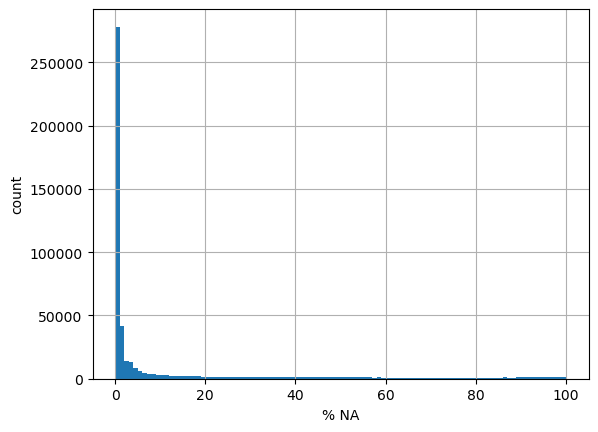

In [110]:
%%time
#looking at a histogram of the percent NAs for the columns
num_nans_hist = 100 * df_t.isna().sum(axis=0)/df_t.shape[0]
num_nans_hist.hist(bins=100)
plt.xlabel('% NA')
plt.ylabel('count')
#plt.ylim(0,50000)

#### Drop all columns with  NAs > 25% of values , then imput with mean of column

In [29]:
# remove columns with more than 25% NAs
df_processed_imp = df_t.dropna(thresh = 0.75*df_t.shape[0], axis=1)

In [30]:
df_processed_imp.shape

(1802, 406628)

In [31]:
%%time
# Impute all values with column mean
df_processed_imp = df_processed_imp.fillna(df_processed_imp.mean())

CPU times: user 5min 56s, sys: 4min 24s, total: 10min 21s
Wall time: 14min 31s


### Writing final dataframe to a file (uncomment and set file to write)

In [32]:
%%time
# write dataframe to a csv file
#file_to_write = 'df_EWAS_aging_whole_blood_Imputated_with_mean'
#df_processed_imp.to_csv(file_to_write)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs


### Selecting out samples with ages over 20 years old

In [33]:
# Selecting out samples with age > 20
df_processed_imp_over20 = df_processed_imp[df_processed_imp.age >=20]

### Histogram of ages in data

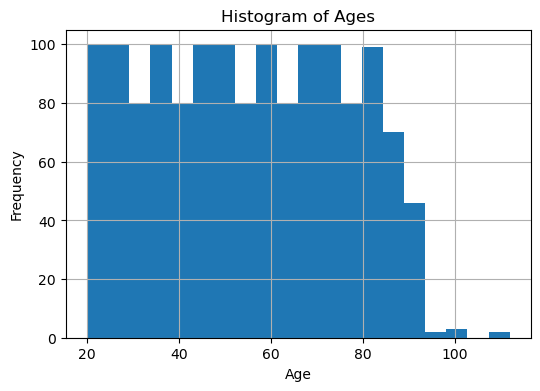

In [109]:
# Histogram of ages in data
plt.figure(figsize = (6,4))
df_processed_imp_over20.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Ages')
plt.show()

### Dividing data into working and saved parts (75/25 split)

In [35]:
df_processed_imp_over20.shape

(1422, 406628)

In [36]:
# Splitting data into Working and Saved by random selection of rows

import random

num_samples = df_processed_imp_over20.shape[0]
num_for_saving = int(round(df_processed_imp_over20.shape[0]*.25))

np.random.seed(2021)

saved_index = np.random.choice(np.arange(num_samples), size=num_for_saving, replace=False)
keep_index = []
for num in range(num_samples):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed_imp_over20.iloc[saved_index, :]
df_p_working = df_processed_imp_over20.iloc[keep_index, :]

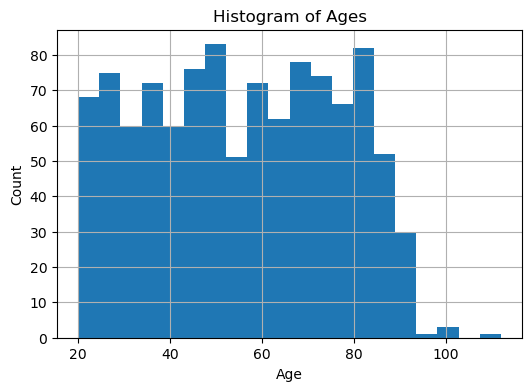

In [101]:
# Histogram of ages in saved data
plt.figure(figsize=(6,4))
df_p_working.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages')
plt.show()

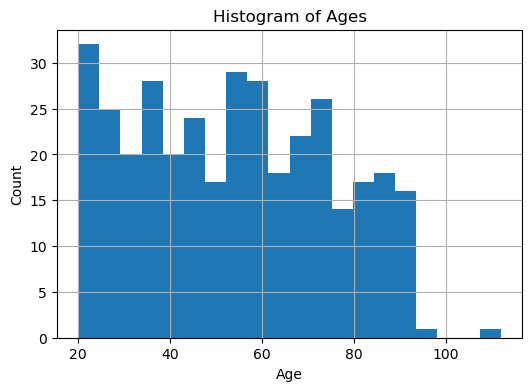

In [102]:
# Histogram of ages in working data
plt.figure(figsize=(6,4))
df_p_saved.age.hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages')
plt.show()

In [39]:
df_p_working

sample_id,tissue,age,cg02494853,cg03706273,cg04023335,cg05213048,cg15295597,cg26520468,cg27539833,cg00008945,cg00011200,cg00011891,cg00014152,cg00016522,cg00016934,cg00018261,cg00021786,cg00026186,cg00072288,cg00072839,cg00074638,cg00112256,cg00114625,cg00114913,cg00116709,cg00139317,cg00140085,cg00142683,cg00192980,cg00200463,cg00206414,cg00240113,cg00241296,cg00241907,cg00243584,cg00264378,cg00265812,cg00266918,cg00360365,cg00373606,cg00374088,cg00378717,cg00378950,cg00380985,cg00381376,cg00391044,cg00399450,cg00408231,cg00412010,cg00412368,...,cg27592453,cg27598806,cg27601574,cg27611781,cg27612019,cg27614432,cg27634071,cg27648216,cg27656573,cg27657363,cg27657537,cg27660038,cg27662611,cg27665648,ch.22.16108507R,ch.22.16454022F,ch.22.40657F,ch.22.78028F,ch.22.17803970R,ch.22.107403R,ch.22.137888R,ch.22.22597277R,ch.22.217069R,ch.22.22928834R,ch.22.23746271F,ch.22.25752197R,ch.22.26167205F,ch.22.317144R,ch.22.26442001R,ch.22.28920330F,ch.22.30020508R,ch.22.427671F,ch.22.439136F,ch.22.467397R,ch.22.31817810F,ch.22.33863861F,ch.22.533187F,ch.22.569473R,ch.22.38010425R,ch.22.694298R,ch.22.707049R,ch.22.707968R,ch.22.740407F,ch.22.757911F,ch.22.43177094F,ch.22.44116734F,ch.22.46830341F,ch.22.1008279F,ch.22.47579720R,ch.22.48274842R
GSM2334366,whole blood,94,0.078,0.205,0.139,0.904,0.120,0.970,0.912,0.276,0.616,0.602,0.986000,0.577,0.274000,0.612,0.888,0.551,0.415,0.112,0.672,0.526,0.641,0.367000,0.630,0.561,0.485,0.579,0.662,0.635,0.449,0.480,0.256,0.288,0.522,0.616,0.602,0.091,0.141963,0.583,0.519,0.019,0.900,0.607,0.017,0.397,0.577,0.532,0.448,0.653,...,0.943,0.948000,0.962,0.064000,0.953,0.020,0.035,0.977,0.975,0.924,0.087,0.096,0.023000,0.882,0.001000,0.002000,0.012000,0.012000,0.160,0.013,0.121,0.016,0.003000,0.014000,0.011,0.002,0.008,0.01400,0.009,0.018000,0.00900,0.017,0.012000,0.005,0.010,0.045,0.011,0.109,0.016,0.011000,0.004000,0.003,0.006000,0.010000,0.004,0.015000,0.010,0.001000,0.047,0.012
GSM989863,whole blood,101,0.013,0.008,0.117,0.756,0.033,0.958,0.933,0.324,0.509,0.519,0.985000,0.529,0.100000,0.629,0.955,0.490,0.318,0.072,0.664,0.569,0.594,0.475000,0.575,0.533,0.420,0.566,0.558,0.520,0.201,0.453,0.293,0.473,0.454,0.434,0.589,0.076,0.143000,0.443,0.401,0.014,0.873,0.473,0.007,0.471,0.554,0.678,0.447,0.513,...,0.907,0.952000,0.967,0.067000,0.649,0.032,0.028,0.967,0.969,0.851,0.093,0.067,0.023000,0.856,0.002000,0.002000,0.014000,0.021000,0.155,0.011,0.177,0.013,0.002000,0.007000,0.004,0.004,0.008,0.01400,0.012,0.020000,0.00300,0.017,0.010000,0.002,0.009,0.061,0.008,0.152,0.015,0.013000,0.000000,0.005,0.008000,0.009000,0.002,0.022000,0.009,0.001000,0.057,0.008
GSM1443696,whole blood,99,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.980993,0.011,0.034000,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.024,0.019000,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,0.099,...,0.859,0.974000,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.026326,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.01984,0.005,0.031775,0.01100,0.005,0.011401,0.003,0.009,0.026,0.002,0.122,0.005,0.025891,0.013469,0.006,0.011000,0.027000,0.000,0.012976,0.003,0.002000,0.033,0.003
GSM1069241,whole blood,99,0.013,0.017,0.477,0.715,0.017,0.966,0.932,0.010,0.014,0.025,0.980993,0.011,0.034000,0.017,0.983,0.002,0.018,0.051,0.632,0.029,0.009,0.052000,0.015,0.018,0.059,0.033,0.035,0.025,0.033,0.038,0.034,0.012,0.285,0.008,0.018,0.024,0.019000,0.021,0.060,0.013,0.933,0.051,0.006,0.088,0.018,0.964,0.152,0.099,...,0.859,0.974000,0.966,0.100000,0.746,0.014,0.020,0.973,0.979,0.861,0.033,0.082,0.032000,0.886,0.019000,0.005000,0.026326,0.069000,0.161,0.001,0.111,0.002,0.014000,0.016000,0.016,0.002,0.002,0.01984,0.005,0.031775,0.01100,0.005,0.011401,0.003,0.009,0.026,0.002,0.122,0.005,0.025891,0.013469,0.006,0.011000,0.027000,0.000,0.012976,0.003,0.002000,0.033,0.003
GSM1572442,w